# PS1#50 - Computing a Histogram
<div style="text-align: right;font-size: 0.8em">Last updated: 2022-11-06</div>

This notebook requires `numpy`, `matplotlib` to run. If the following cell raises an error, install them first.
It also requires Python at least `3.10` for some type annotations. If these annotations cause errors, feel free to remove them.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1234)

The goal of this exercise is to compute a histogram from independent realizations of a random variable.

The random variable $X$ has the following form: $$X = \mathrm{proj}_{[-3, 8]}(B\cdot G_1 + (1 - B)\cdot G_2),$$ where $B\sim\mathcal{B}(0.5)$, $G_1\sim\mathcal{N}(-1, 0.5)$, $G_2\sim\mathcal{N}(\pi, 1.5)$, and $\mathrm{proj}_{[-3, 8]}(x)$ denotes the projection of $x$ on the interval $[-3, 8]$.
The PDF of $B\cdot G_1 + (1 - B)\cdot G_2$ is plotted below. The one of $X$ looks very much alike.

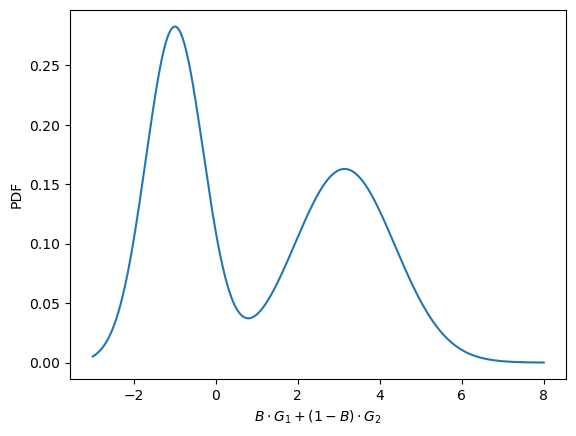

In [2]:
def pdf_unprojected(x):
    m1 = -1
    m2 = np.pi
    s1 = 0.5
    s2 = 1.5
    b = 0.5
    norm1 = 1 / np.sqrt(2*np.pi * s1)
    norm2 = 1 / np.sqrt(2*np.pi * s2)
    pdf = b * norm1 * np.exp(-(x - m1)**2/(2*s1)) + (1 - b) * norm2 * np.exp(-(x - m2)**2/(2*s2))
    return pdf

x = np.linspace(-3, 8, 1001)
y = pdf_unprojected(x)
plt.figure()
plt.plot(x, y, label="PDF (before projection)")
plt.xlabel(r"$B\cdot G_1 + (1 - B)\cdot G_2$")
plt.ylabel(r"PDF")
plt.show()

The function below outputs $N$ independent realizations of $X$:

In [3]:
def get_independent_realizations(N:int) -> np.ndarray:
    """ Returns N independent realizations of the random variable $X$
    Args:
        N: number of realizations
    Returns:
        The realizations as an array of shape (N,)
    """
    a = 0.5
    b = np.atleast_1d(np.random.binomial(1, a, N))
    c = np.array([[0, 1]]*b.shape[0]) == b.reshape(-1, 1)
    d = np.array([[-1, np.pi]] * b.shape[0])
    e = np.array([[0.5, 1.5]] * b.shape[0])
    f = np.random.normal(loc=d[c], scale=e[c]).clip(-3, 8)

    return f

We will consider two possible subdivisions of length $K = 22$: the regular subdivision $a_k = a + k\cdot\frac{b-a}{K}$, and another one with an irregular step.

They can be obtained by calling the function defined below with parameter `1` or `2`, respectively.

In [4]:
a = -3
b = 8
K = 21

def get_subdivision(id: int):
    if id == 1:
        return np.array([a + k * (b - a)/K for k in range(K+1)])
    elif id == 2:
        return np.array(
            [-3., -2., -1.5, -1.25, -1, -0.75, -.5, 0., 1., 2., 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4., 5., 6., 7., 8.]
        )
    else:
        raise ValueError('The ID should be 1 or 2')

Finally, the function below is a helper for plotting:

In [5]:
def plot_subdvision_up_to_y(x, y, subdivision_id, **kwargs):
    sub = get_subdivision(subdivision_id)
    ind_of_sub = np.argmin(
        np.abs(
            x.reshape(-1, 1) - sub.reshape(1, -1)
        ),
        axis=0
    ).flatten()
    y_shifted_p1 = np.hstack((y[1:], [0]))
    y_shifted_m1 = np.hstack(([0], y[:-1]))
    value_to_plot = np.max(
        np.vstack((y, y_shifted_p1, y_shifted_m1)),
        axis=0
    )
    plt.vlines(sub, 0, value_to_plot[ind_of_sub], **kwargs)

## Part 1
We start by implementing functions that compute the different variables.

### Question 1
Fill in the function `indicator` that returns $1$ if its argument $x$ is in $I_k$ and $0$ otherwise.

In [6]:
def indicator(x: np.ndarray, k: int, subdivision_id: int) -> np.ndarray:
    """ Returns 1 if `x` is in the interval $I_k$ of the subdivision `subdivision_id`, and 0 otherwise.
    Args:
        x: the number or array of numbers to test
        k: the index of the interval
        subdivision_id: either 1 or 2; directly passed to get_subdivision
    Returns:
        An array whose $i$-th component is 1 if x[i] is in $I_k$, 0 otherwise. 
        It has the same shape as x.
    """
    assert k >= 1 and k <= K, f"Invalid k (k = {k})"
    sub = get_subdivision(subdivision_id)

    ### BEGIN SOLUTION
    if k == K:
        return np.logical_and(x >= sub[k-1], x <= sub[k]).astype(int)
    else:
        return np.logical_and(x >= sub[k-1], x < sub[k]).astype(int)
    ### END SOLUTION

### Question 2

Fill in the function `get_counts` that transforms an array of $N$ realizations of $X$ into an array of length $K$ whose $k$-th component is the value of $C_k^N$.

In [7]:
def get_counts(realizations: np.ndarray, subdivision_id: int) -> np.ndarray:
    """ Returns the array of values of $C_k^N$ given realizations of $X$
    Args:
        realizations: array of shape (N,) representing the realizations of $X$
        subdivision_id: either 1 or 2; directly passed to get_subdivision
    Returns:
        An array of shape (K,) whose $k$-th value is the value of $C_k^N$
    """
    ### BEGIN SOLUTION
    return np.array([
        (indicator(realizations, k, subdivision_id)).sum() for k in range(1, K+1)
    ])
    ### END SOLUTION

In [8]:
realizations = get_independent_realizations(50)
assert get_counts(realizations, 1).shape == (K,)
assert get_counts(realizations, 1).sum() == realizations.shape[0]

### Question 3

Fill in the function `get_frequencies` that transforms the array of values of $C_k^N$ into the one of the values of $F_k^N$.

_Hint: the total number of realizations is the sum of all the counts_

In [9]:
def get_frequencies(counts: np.ndarray) -> np.ndarray:
    """ Returns the array of values of $F_k^N$ given the one of $C_k^N$.
    Args:
        counts: array of shape (K,) whose $k$-th value is the value of $C_k^N$
    Returns:
        An array of shape (K,) whose $k$-th value is the value of $F_k^N$
    
    """
    ### BEGIN SOLUTION
    N = counts.sum()
    return counts / N
    ### END SOLUTION

In [10]:
counts = get_counts(get_independent_realizations(50), 1)
freqs = get_frequencies(counts)
assert freqs.shape == (K,), f"The shape should be (K,). You have: {freqs.shape}"
assert np.isclose(freqs.sum(), 1), f"The sum of frequencies should be 1. You have: {freqs.sum()}"

## Part 2

We explore how to approximate the function $f$ from independent samples of $X$.

### Question 4
Fill in the function `approximate_f_in_bins` that takes as input the number $N$ of realizations of $X$ to use and outputs the array of shape `(K,)` of approximate values of $f$ in the intervals $I_k$.

In [11]:
def approximate_f_in_bins(N: int, subdivision_id: int) -> np.ndarray:
    """ Computes the approximate value of $f$ in each bin as estimated by $F_k^N$.
    Args:
        N: the number of realizations of $X$
        subdivision_id: either 1 or 2; directly passed to get_subdivision
    Returns:
        The value of $f$. If $x$ is an array, the output is an array with the same shape.
    """
    ### BEGIN SOLUTION
    realizations = get_independent_realizations(N)
    counts = get_counts(realizations, subdivision_id)
    freqs = get_frequencies(counts)
    return freqs
    ### END SOLUTION

### Question 5
Fill in the function `approximate_f` that takes as inputs an array of points `x` where to evaluate the approximation of $f$ and the number $N$ of realizations to use in the approximations and outputs the approximate value.

In [12]:
def approximate_f(x: np.ndarray, N: int, subdivision_id: int) -> np.ndarray:
    """ Computes the approximate value f(x) as estimated by the $F_k^N$'s.
    Args:
        x: the array of points where to evaluate the approximation
        N: the number of realizations of $X$
        subdivision_id: either 1 or 2; directly passed to get_subdivision
    Returns:
        An array whose $i$-th entry is the approximate value of $f(x[i])$.
        It has the same shape as `x`.
    """
    ### BEGIN SOLUTION
    # Shape: (K, 1)
    f_vals = approximate_f_in_bins(N, subdivision_id)[:, np.newaxis]
    # Shape: (K, N)
    indicators = np.array([indicator(x, k, subdivision_id) for k in range(1, K+1)])
    return (indicators * f_vals).sum(axis=0)
    ### END SOLUTION

### Question 6

The function `plot_approximate_f` uses your implementation of `approximate_f_in_bins` to plot the approximation of the PMF and compare it against the true PMF.

Run it several times with increasing values of $N$, e.g., $N\in\{10, 25, 100, 1000\}$. Use `subdivision_id = 1`. Comment.

In [13]:
def plot_approximate_f(N: int, subdivision_id: int) -> None:
    x = np.linspace(a, b, 100, endpoint=True)
    approx_f = approximate_f(x, N, subdivision_id)
    plt.plot(x, approx_f, label='Approximation of $f$')
    plot_subdvision_up_to_y(x, approx_f, subdivision_id, color='red', alpha=0.1)
    plt.plot(x, pdf_unprojected(x), color='green', label=r"PDF")
    plt.xlabel(r'$x$')
    plt.ylabel('f(x)')
    plt.title(f'Approximation of $f$ ($N = {N}$)')
    plt.ylim(0, 0.4)
    plt.legend()
    plt.show()

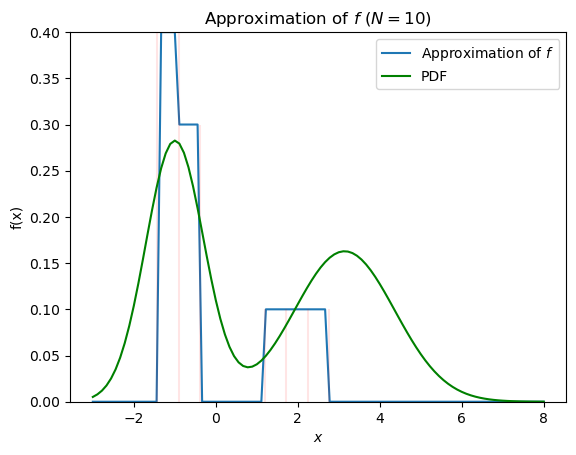

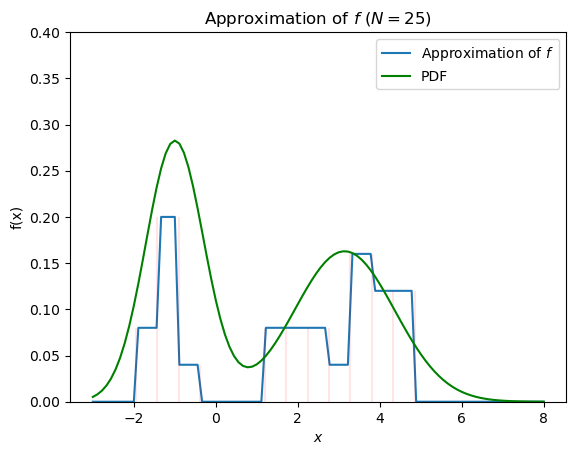

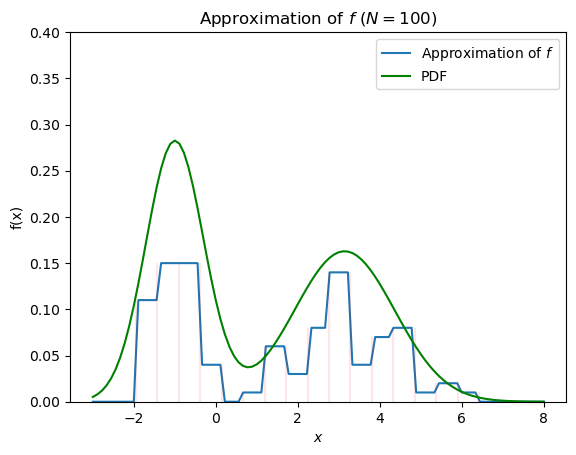

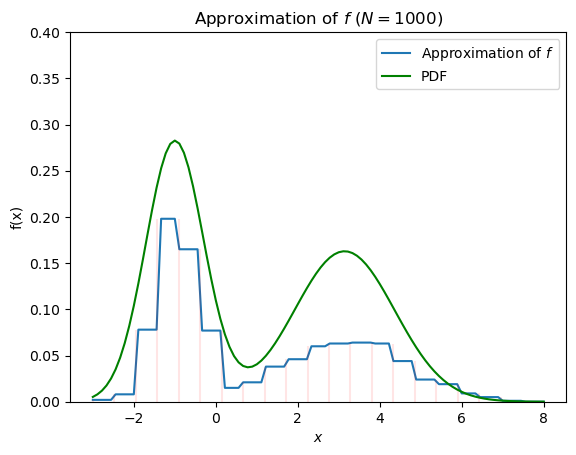

In [14]:
### BEGIN SOLUTION
plot_approximate_f(10, 1)
plot_approximate_f(25, 1)
plot_approximate_f(100, 1)
plot_approximate_f(1000, 1)
### END SOLUTION

## Part 3

We investigate why $g$ is a better approximation of the PDF than $f$ is.

### Question 7
Fill in the functions `approximate_g_in_bins` and `approximate_g` that respectively:
* takes as input the number $N$ of realizations of $X$ to use and outputs the array of shape `(K,)` of approximate values of $f$ in the intervals $I_k$;
* takes as inputs an array of points `x` where to evaluate the approximation of $f$ and the number $N$ of realizations to use in the approximations and outputs the approximate value.

In [15]:
def approximate_g_in_bins(N: int, subdivision_id: int) -> np.ndarray:
    """ Computes the approximate value of $g$ in each bin as estimated by $(a_k - a_{k-1})F_k^N$.
    Args:
        N: the number of realizations of $X$
        subdivision_id: either 1 or 2; directly passed to get_subdivision
    Returns:
        The value of $f$. If $x$ is an array, the output is an array with the same shape.
    """
    ### BEGIN SOLUTION
    sub = get_subdivision(subdivision_id)
    realizations = get_independent_realizations(N)
    counts = get_counts(realizations, subdivision_id)
    freqs = get_frequencies(counts) / np.diff(sub)
    return freqs
    ### END SOLUTION

def approximate_g(x: np.ndarray, N: int, subdivision_id: int) -> np.ndarray:
    """ Computes the approximate value g(x) as estimated by the $F_k^N$'s.
    Args:
        x: the array of points where to evaluate the approximation
        N: the number of realizations of $X$
        subdivision_id: either 1 or 2; directly passed to get_subdivision
    Returns:
        An array whose $i$-th entry is the approximate value of $f(x[i])$.
        It has the same shape as `x`.
    """
    ### BEGIN SOLUTION
    # Shape: (K, 1)
    f_vals = approximate_g_in_bins(N, subdivision_id)[:, np.newaxis]
    # Shape: (K, N)
    indicators = np.array([indicator(x, k, subdivision_id) for k in range(1, K+1)])
    return (indicators * f_vals).sum(axis=0)
    ### END SOLUTION

### Question 8
Fill in the functions `integral_f` and `integral_g`, that respectively compute the integrals of $f$ and $g$ given $N$ and the subdivision on the interval $[a, b]$.

_Hint: use the fact that $f$ and $g$ are piecewise constant, and use `np.diff`_

In [16]:
def integral_f(N: int, subdivision_id: int) -> float:
    """ Computes the integral of the approximation of $f$.
    Args:
        N: the number of realizations of $X$
        subdivision_id: either 1 or 2; directly passed to get_subdivision
    Returns:
        The integral of $f$
    """
    ### BEGIN SOLUTION
    sub = get_subdivision(subdivision_id)
    freqs = get_frequencies(counts) * np.diff(sub)
    return freqs.sum()
    ### END SOLUTION

def integral_g(N: int, subdivision_id: int) -> float:
    """ Computes the integral of the approximation of $f$.
    Args:
        N: the number of realizations of $X$
        subdivision_id: either 1 or 2; directly passed to get_subdivision
    Returns:
        The integral of $f$
    """
    ### BEGIN SOLUTION
    freqs = get_frequencies(counts)
    return freqs.sum()
    ### END SOLUTION

The function `plot_integrals` uses your implementations to plot the integrals for different values of $N$ and with the first subdivision. Run the cell below, and comment.

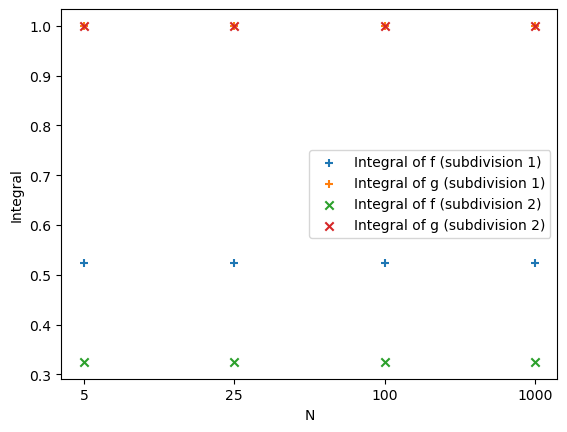

In [17]:
def plot_integrals() -> None:
    values_N = (5, 25, 100, 1000)
    ints_f_1 = np.array([0.] * len(values_N))
    ints_g_1 = np.array([0.] * len(values_N))
    ints_f_2 = np.array([0.] * len(values_N))
    ints_g_2 = np.array([0.] * len(values_N))
    for i, N in enumerate(values_N):
        ints_f_1[i] = integral_f(N, subdivision_id=1)
        ints_g_1[i] = integral_g(N, subdivision_id=1)
        ints_f_2[i] = integral_f(N, subdivision_id=2)
        ints_g_2[i] = integral_g(N, subdivision_id=2)
    x = np.arange(len(values_N))
    plt.scatter(x, ints_f_1, label='Integral of f (subdivision 1)', marker='+')
    plt.scatter(x, ints_g_1, label='Integral of g (subdivision 1)', marker='+')
    plt.scatter(x, ints_f_2, label='Integral of f (subdivision 2)', marker='x')
    plt.scatter(x, ints_g_2, label='Integral of g (subdivision 2)', marker='x')
    plt.xticks(ticks=x, labels=values_N)
    plt.xlabel('N')
    plt.ylabel('Integral')
    plt.legend()
    plt.show()
plot_integrals()

## Question 9

Contrary to $g$, the bins of the function $f$ are not normalized and depend on the amplitude of $a_k - a_{k-1}$.
This becomes problematic when having bin sizes of different width, as is the case with subdivision $2$.

The function below plots the approximations of $f$ and $g$ for $N = 10000$ for both subdivisions. Comment.

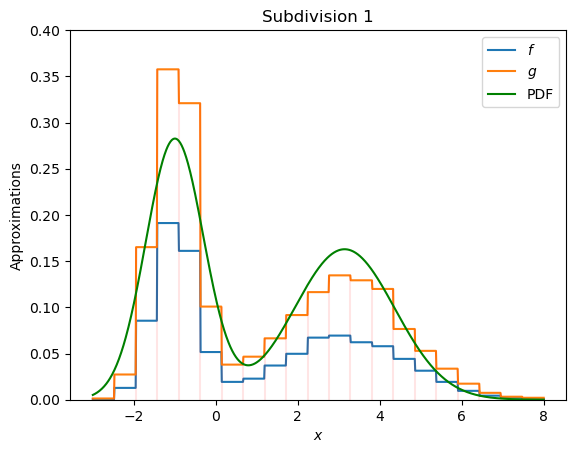

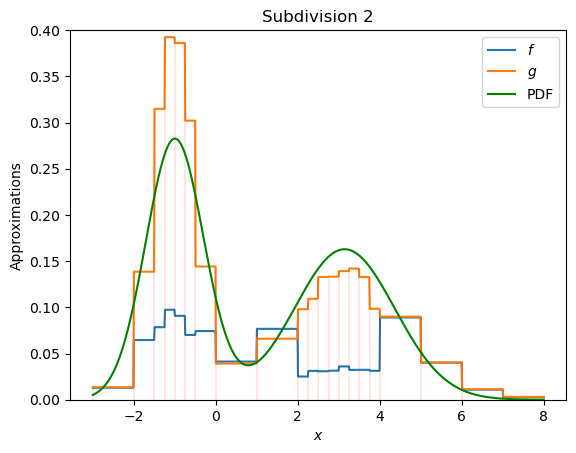

In [18]:
def plot_approximations():
    N = 10000
    x = np.linspace(a, b, 1001, endpoint=True)
    for s in (1, 2):
        plt.figure()
        approx_f = approximate_f(x, N, subdivision_id=s)
        approx_g = approximate_g(x, N, subdivision_id=s)
        plt.plot(x, approx_f, label='$f$')
        plt.plot(x, approx_g, label='$g$')
        plot_subdvision_up_to_y(x, np.maximum(approx_f, approx_g), s, color='red', alpha=0.1)
        plt.plot(x, pdf_unprojected(x), color='green', label=r"PDF")
        plt.xlabel(r'$x$')
        plt.ylabel('Approximations')
        plt.title(f'Subdivision {s}')
        plt.ylim(0, 0.4)
        plt.legend()

plot_approximations()